In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1_F11.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1_F11.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11/models'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv1_F11/models'


In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11/models/plots/model'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV   GSD     n     k
0  0.97      0.95  0.96  0.62  0.81

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV   GSD     n     k
r2  0.97      0.95  0.96  0.62  0.81

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot    RmedianV       GSD         n         k
0        0.062477    0.842050  0.007419  0.150808  0.024793
1        0.721892  295.193635  0.080884  0.049711  0.104035
2        3.019355   15.952077  0.001779  0.365648  0.433414
3        4.157847   27.390097  0.124674  0.055087  0.286391
4       29.576751    2.041542  0.096814  0.400797  0.072647
...           ...         ...       ...       ...       ...
19464    8.093166   15.267312  0.116606  0.000878  0.041315
19465    0.070475    1.742100  0.003670  0.005510  0.052058
19466    0.347083    3.855806  0.045289  0.509689  0.259881
19467  150.289874   53.278704  0.168237  0.145374  0.021370
19468    3.259456   17.057988  0.124171  0.154096  0.095235

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    3.59     19.67  0.06  0.13  0.11
75%   37.88    144.17  0.12  0.28  0.30
90%  173.75    491.99  0.19  0.50  0.49
95%  348.49    729.97  0.23  0.64  0.61
99%  847.22   1124.05  0.34  0.94  0.80

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot   RmedianV       GSD          n          k
0       1.261388   0.188336  0.439679   5.749896   3.287320
1       7.326226   9.996023  3.069144   2.380826   5.820462
2      10.900193   6.265851  0.170423  12.549277  39.358479
3       8.483407   5.272940  5.704411   2.330203  13.931698
4       6.700256   2.031970  4.390169  13.899056   3.662714
...          ...        ...       ...        ...        ...
19464   0.278797   6.236177  5.691568   0.060170   8.814757
19465   1.857910   0.852515  0.304229   0.352720   4.812025
19466   3.860477   0.730158  2.322881  18.951452  13.867836
19467   6.349211   6.829799  6.582563   5.179346   3.971495
19468   3.861838  10.115472  4.813077   6.011512   8.625654

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV    GSD      n       k
50%   5.80      4.58   3.10   6.19   12.83
75%  13.06      9.46   5.57  12.32   26.55
90%  26.37     19.01   8.42  21.33   43.56
95%  38.49     28.31  10.91  29.21   54.33
99%  67.10     49.05  18.26  53.42  156.12

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV   GSD     n      k
0  10.69     11.44  4.18  9.46  17.22

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV    GSD      n      k
r2               0.97      0.95   0.96   0.62   0.81
abs error 90%  173.75    491.99   0.19   0.50   0.49
abs error 95%  348.49    729.97   0.23   0.64   0.61
rel error 90%   26.37     19.01   8.42  21.33  43.56
rel error 95%   38.49     28.31  10.91  29.21  54.33
wmape           10.69     11.44   4.18   9.46  17.22

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']

j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    


    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


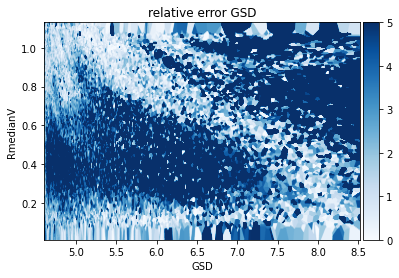

In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

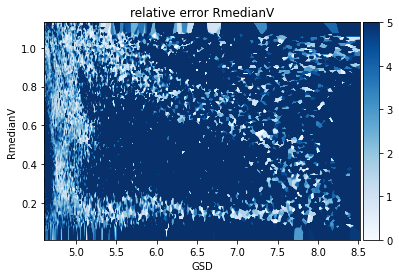

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

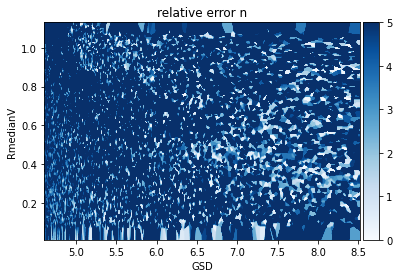

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

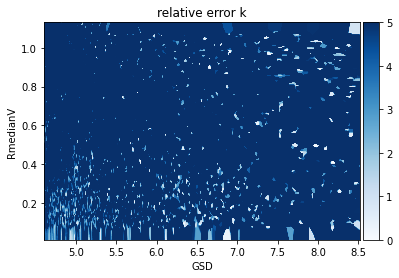

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  1.0 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0     1.0  ...      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

   F11_168  F11_169  F11_170  
0      1.0      1.0      1.0  

[1 rows x 152 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11  PPF
r2  1.0  NaN

In [47]:
r2_adj_iv.values

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10     F11_11     F11_12     F11_13     F11_14     F11_15  \
0        0.565492   0.527393   0.429128   0.403614   0.338917   0.334874   
1        0.102468   0.097074   0.066411   0.041632   0.032871   0.013244   
2        3.985585   1.561926   0.615752   0.713840   2.271092   3.325663   
3        0.062119   1.033845   1.435670   1.148991   0.382814   0.633607   
4        9.113248  19.893893  25.084548  22.645642  13.736639   5.690884   
...           ...        ...        ...        ...        ...        ...   
19464   42.048422  71.622301  99.242511  97.058420  85.993088   1.115543   
19465    0.025663   0.140965   0.150968   0.106643   0.022768   0.040875   
19466    0.238101   0.003915   0.165425   0.175473   0.051392   0.003346   
19467  108.305691  11.455489  25.428506   4.557874  13.745874  48.172467   
19468    1.189406   2.652995   4.078586   3.877346   3.657119   1.757734   

          F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0       0.322932   0.343803   0.345162   0.352864  ...  0.007726  0.007695   
1       0.005541   0.005709   0.002220   0.004022  ...  0.000085  0.000442   
2       2.699298   2.676871   1.961137   1.315126  ...  0.190015  0.189343   
3       1.091198   1.147258   1.126441   1.067416  ...  0.009990  0.024306   
4       2.690818  10.561699   7.761036  13.677385  ...  0.192892  0.409557   
...          ...        ...        ...        ...  ...       ...       ...   
19464  34.788140  56.131437  71.102510  73.324567  ...  0.407363  0.063515   
19465   0.120558   0.000812   0.119197   0.112175  ...  0.020021  0.018810   
19466   0.016341   0.009350   0.020169   0.032640  ...  0.007061  0.008240   
19467  70.756378  78.289665  74.598452  65.148305  ...  0.535251  0.606766   
19468   1.242218   0.522912   0.205253   0.077134  ...  0.177288  0.236326   

        F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0      0.008321  0.008289  0.007617  0.007783  0.008150  0.007675  0.007895   
1      0.000368  0.000629  0.000255  0.000507  0.001091  0.000660  0.000791   
2      0.191766  0.171221  0.177831  0.175374  0.171827  0.155642  0.173801   
3      0.031751  0.038673  0.047100  0.064791  0.059826  0.062603  0.081231   
4      1.742263  0.931296  0.775957  2.034175  1.980041  1.064129  3.394637   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.066782  0.097585  0.189400  0.766269  0.312845  0.123756  0.145964   
19465  0.019571  0.019001  0.018544  0.015788  0.018270  0.015957  0.017121   
19466  0.009543  0.009833  0.011850  0.012865  0.012855  0.014746  0.016564   
19467  0.647059  1.064084  1.019508  1.401847  1.509717  1.831806  1.777997   
19468  0.213618  0.315514  0.329596  0.487865  0.500011  0.526745  0.569427   

        F11_170  
0      0.007369  
1      0.000990  
2      0.144377  
3      0.084209  
4      2.640878  
...         ...  
19464  0.042078  
19465  0.016075  
19466  0.016909  
19467  2.229077  
19468  0.653106  

[19469 rows x 152 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.52    1.20    1.16    0.97    0.78    0.65    0.61    0.60    0.55   
75%   14.32   11.93   11.77    9.79    7.60    6.18    5.98    6.30    6.11   
90%   67.59   57.01   59.25   50.34   39.41   33.00   34.51   37.09   39.18   
95%  135.55  118.15  118.68  104.30   82.85   71.20   74.72   81.64   86.81   
99%  385.12  329.27  324.69  271.61  233.21  212.62  222.32  227.94  234.27   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    0.48  ...     0.03     0.03     0.03     0.03     0.04     0.04   
75%    5.27  ...     0.26     0.30     0.30     0.33     0.35     0.42   
90%   35.00  ...     1.57     1.83     1.79     2.00     2.14     2.42   
95%   78.15  ...     4.06     4.69     4.56     5.19     5.43     6.41   
99%  214.23  ...    18.28    19.96    20.92    22.26    22.73    26.50   

     F11_167  F11_168  F11_169  F11_170  
50%     0.04     0.04     0.04     0.05  
75%     0.41     0.45     0.45     0.51  
90%     2.45     2.60     2.63     2.93  
95%     6.33     6.91     7.09     7.80  
99%    26.36    28.56    29.18    32.42  

[5 rows x 152 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      2.834110  2.884400  2.568013  2.648378  2.442392  2.653598  2.816172   
1      1.275128  1.500176  1.256442  0.952103  0.898468  0.428255  0.209995   
2      3.881409  1.555967  0.628823  0.748940  2.453270  3.706760  3.111095   
3      0.035422  0.654787  1.007881  0.892192  0.328074  0.597990  1.131655   
4      0.947652  2.109808  2.715696  2.504784  1.553443  0.658424  0.318691   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.535796  0.964973  1.415675  1.467457  1.379222  0.018993  0.629057   
19465  0.213783  1.194563  1.303512  0.939696  0.205073  0.376915  1.139915   
19466  0.712788  0.013050  0.613677  0.723711  0.235358  0.016993  0.091867   
19467  1.701366  0.204675  0.513979  0.103711  0.350510  1.370788  2.238128   
19468  0.504596  1.176757  1.891547  1.880062  1.853729  0.931200  0.687642   

         F11_17    F11_18    F11_19  ...    F11_161    F11_162    F11_163  \
0      3.301230  3.650152  4.109710  ...   3.862033   3.838748   4.141762   
1      0.251442  0.112735  0.233805  ...   0.077015   0.400262   0.332696   
2      3.197248  2.432663  1.697869  ...  12.170803  12.106446  12.228865   
3      1.304549  1.401391  1.449811  ...   0.255038   0.619172   0.807007   
4      1.281150  0.964627  1.742552  ...   0.095813   0.202763   0.859822   
...         ...       ...       ...  ...        ...        ...        ...   
19464  1.078432  1.451853  1.591554  ...   0.429806   0.066938   0.070299   
19465  0.007886  1.190593  1.154292  ...   7.761478   7.264207   7.529986   
19466  0.058095  0.138248  0.246359  ...   1.270688   1.480176   1.710919   
19467  2.742771  2.884691  2.771816  ...   0.577399   0.652560   0.693789   
19468  0.302374  0.123944  0.048624  ...   1.037817   1.379287   1.243123   

         F11_164    F11_165    F11_166    F11_167   F11_168    F11_169  \
0       4.116473   3.774069   3.847540   4.019418  3.776149   3.875525   
1       0.569073   0.230935   0.457801   0.985166  0.595910   0.713766   
2      10.881545  11.256120  11.050542  10.774424  9.710094  10.787085   
3       0.980664   1.191561   1.635239   1.506360  1.572586   2.035805   
4       0.458210   0.380679   0.995224   0.966244  0.518034   1.648857   
...          ...        ...        ...        ...       ...        ...   
19464   0.102602   0.198898   0.803724   0.327743  0.129497   0.152561   
19465   7.283805   7.083004   6.009314   6.931035  6.034556   6.455025   
19466   1.759274   2.115727   2.292148   2.285340  2.615884   2.931901   
19467   1.137509   1.086636   1.489828   1.599958  1.936041   1.874306   
19468   1.830926   1.907453   2.816059   2.879026  3.025859   3.263864   

        F11_170  
0      3.609491  
1      0.893114  
2      8.914935  
3      2.105741  
4      1.280088  
...         ...  
19464  0.043931  
19465  6.043821  
19466  2.986611  
19467  2.344069  
19468  3.735863  

[19469 rows x 152 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.50    1.40    1.53    1.46    1.32    1.25    1.34    1.44    1.51   
75%    2.72    2.60    2.79    2.59    2.37    2.30    2.37    2.51    2.61   
90%    4.63    4.41    4.52    4.09    3.75    3.67    3.74    3.89    3.94   
95%    6.55    6.28    6.32    5.73    5.09    5.18    5.12    5.33    5.27   
99%   17.15   13.95   12.88   13.42   13.82   11.99   11.31   11.17   12.20   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    1.49  ...     1.36     1.53     1.53     1.76     1.79     2.07   
75%    2.54  ...     2.26     2.45     2.46     2.69     2.76     3.08   
90%    3.84  ...     3.67     3.88     3.92     4.12     4.24     4.58   
95%    5.17  ...     5.35     5.57     5.68     5.87     6.07     6.31   
99%   12.94  ...    12.83    13.34    13.80    13.83    14.13    14.67   

     F11_167  F11_168  F11_169  F11_170  
50%     2.06     2.20     2.22     2.43  
75%     3.11     3.29     3.35     3.59  
90%     4.66     4.84     4.91     5.18  
95%     6.47     6.79     6.95     7.34  
99%    15.43    16.39    16.63    18.03  

[5 rows x 152 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      1.52
75%     14.32
90%     67.59
95%    135.55
99%    385.12
dtype: float64
Absolute error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Relative error F11
50%     2.43
75%     3.59
90%     5.18
95%     7.34
99%    18.03
dtype: float64
Relative error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    1.98    1.89    2.06    1.97    1.74    1.68    1.84    2.11    2.32   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0    2.25  ...      2.4     2.62     2.66      2.9     3.01     3.42     3.44   

   F11_168  F11_169  F11_170  
0     3.67     3.72     4.09  

[1 rows x 152 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11  PPF
r2               1.000000  NaN
abs error 90%   67.590000  NaN
abs error 95%  135.550000  NaN
rel error 90%    5.180000  NaN
rel error 95%    7.340000  NaN
wmape            1.998016  NaN

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

## 2. plots

In [58]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

In [59]:
qoi_pred

F11_10       F11_11       F11_12       F11_13       F11_14  \
0        19.387586    17.756921    16.281385    14.836426    13.537510   
1         8.138391     6.567930     5.352089     4.414283     3.691477   
2        98.698389    98.821069    97.305579    94.599513    90.302952   
3       175.303979   158.924036   143.880076   129.931875   117.067910   
4       970.779331   962.818090   948.772034   926.741080   898.006999   
...            ...          ...          ...          ...          ...   
19464  7889.887958  7493.833001  7109.502282  6711.112408  6320.892838   
19465    12.029909    11.941506    11.732623    11.455285    11.125372   
19466    33.166033    29.994340    27.121749    24.421766    21.886941   
19467  6257.502228  5585.474093  4972.810831  4399.351529  3907.929104   
19468   236.903677   228.102577   219.700355   210.112396   200.941579   

            F11_15       F11_16       F11_17       F11_18       F11_19  ...  \
0        12.284760    11.144133    10.070576     9.110940     8.233249  ...   
1         3.105901     2.644238     2.276334     1.971486     1.724353  ...   
2        86.393197    84.064298    81.047373    78.655727    76.142312  ...   
3       105.322482    95.333811    86.795630    79.253771    72.557114  ...   
4       870.009749   841.642302   813.830521   796.802710   771.227928  ...   
...            ...          ...          ...          ...          ...  ...   
19464  5872.405974  5495.417732  5148.782012  4826.261608  4533.780006  ...   
19465    10.803809    10.455503    10.298750     9.892334     9.605889  ...   
19466    19.695978    17.771796    16.085793    14.569168    13.216325  ...   
19467  3466.043801  3090.652463  2776.110263  2511.413887  2285.235004  ...   
19468   190.517873   181.891154   173.458079   165.396719   158.555009  ...   

          F11_161     F11_162     F11_163     F11_164     F11_165     F11_166  \
0        0.192313    0.192762    0.192575    0.193062    0.194201    0.194509   
1        0.110354    0.110027    0.110137    0.109916    0.110335    0.110134   
2        1.751256    1.753327    1.759905    1.744723    1.757696    1.762396   
3        3.907051    3.901285    3.902688    3.904857    3.905697    3.897381   
4      201.128697  202.398015  204.372988  204.178041  204.610861  206.427805   
...           ...         ...         ...         ...         ...         ...   
19464   95.185596   94.822010   95.063150   95.012164   95.035196   94.573534   
19465    0.277973    0.277746    0.279482    0.279871    0.280351    0.278505   
19466    0.548625    0.548462    0.548234    0.549070    0.548221    0.548406   
19467   92.165144   92.375610   92.617457   92.481027   92.802890   92.692719   
19468   16.905464   16.897637   16.970322   16.916960   16.949765   16.836531   

          F11_167     F11_168     F11_169     F11_170  
0        0.194621    0.195572    0.195820    0.196800  
1        0.109604    0.110093    0.110024    0.109889  
2        1.766590    1.758530    1.784998    1.763875  
3        3.911747    3.918311    3.908871    3.914826  
4      206.901431  206.480841  209.272816  208.945324  
...           ...         ...         ...         ...  
19464   95.141378   95.442920   95.530003   95.738816  
19465    0.281865    0.280392    0.282350    0.282050  
19466    0.549637    0.548975    0.548382    0.549239  
19467   92.850042   92.784272   93.083600   92.865297  
19468   16.867368   16.881368   16.876980   16.828969  

[19469 rows x 152 columns]

In [61]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
  #  pms_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
  #  meas_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
  #  axs[nr,1].set_ylabel('PPF [-]')
  #  axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')